# Performance Comparison

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from typing import List
import os

root_path = './'  # Replace with the actual folder path

In [20]:
def load_logfiles(folder_path):
    file_names = os.listdir(folder_path)
    prefixes = ['FI', 'NJ', 'EM', 'RA', 'DQ', 'A2', 'PP', 'Re', 'GT'] #
    values = ['FIFO', 'NJF', 'EMPTY', 'RANDOM', 'DQN', 'A2C','PPO', 'RecPPO', 'GTrXL'] #
    mapping = {prefix: value for prefix, value in zip(prefixes, values)}
    filtered_dict = {}

    for file_name in file_names:
        if file_name[:2] == 'Me' or file_name[:2] == 'He':
            continue
        elif len(file_name) >= 2 and file_name[-3:] == 'txt':
            prefix = file_name[:2]
            if mapping[prefix] not in filtered_dict:
                filtered_dict.update({mapping[prefix]: []})

            if 'agent_reward' in file_name:
                filtered_dict[mapping[prefix]].append(file_name)
            else:
                filtered_dict[mapping[prefix]].insert(0, file_name)

    return filtered_dict

In [3]:
def read_logfiles(path:str, episode_log:str, reward_log:str=None):
    ep_log = pd.read_csv(path+episode_log, sep=',')
    if reward_log is not None:
        agent_log = pd.read_csv(path+reward_log, sep=',')
        return ep_log, agent_log
    return ep_log

In [4]:
def extract_kpi(episode_log:pd.DataFrame, alg):
    perf_kpi = pd.DataFrame()
    if alg == 'FIFO' or alg == 'NJF' or alg == 'EMPTY' or alg == 'RANDOM':
        perf_kpi['alpha'] = episode_log['alpha'].values #+ 0.22
        perf_kpi['inventory'] = episode_log['inventory'].values #+ 2.75
        perf_kpi['order_waiting_time'] = episode_log['order_waiting_time'].values #+ 25.3
        perf_kpi['machines_working'] = episode_log['machines_working'].values #- 0.02
        perf_kpi['total_reward'] = episode_log['total_reward'].values #- 14
        perf_kpi['transp_working'] = episode_log['transp_working'].values #- 0.01
        perf_kpi['processed_orders'] = episode_log['processed_orders'].values #- 41
    else:
        perf_kpi['alpha'] = episode_log['alpha'].values
        perf_kpi['inventory'] = episode_log['inventory'].values
        perf_kpi['order_waiting_time'] = episode_log['order_waiting_time'].values
        perf_kpi['machines_working'] = episode_log['machines_working'].values
        perf_kpi['total_reward'] = episode_log['total_reward'].values
        perf_kpi['transp_working'] = episode_log['transp_working'].values
        perf_kpi['processed_orders'] = episode_log['processed_orders'].values
        
    return perf_kpi

In [5]:
def mean_kpi(perf_kpi:pd.DataFrame, file_path:str, name:str, printer=False, saver=True):
    means = {
        'alpha': perf_kpi['alpha'].iloc[-1000:-500].mean(),
        'inventory': perf_kpi['inventory'].iloc[-1000:-500].mean(),
        'order_waiting_time': perf_kpi['order_waiting_time'].iloc[-1000:-500].mean(),
        'machines_working': perf_kpi['machines_working'].iloc[-1000:-500].mean(),
        'max_reward': perf_kpi['total_reward'].iloc[-1000:-500].max(),
        'transp_util': perf_kpi['transp_working'].iloc[-1000:-500].mean(),
        'throughput': perf_kpi['processed_orders'].iloc[-1000:-500].mean()
    }
    genGap = {
        'alpha': perf_kpi['alpha'].iloc[-1000:-500].mean() - perf_kpi['alpha'].iloc[-500:].mean(),
        'inventory': perf_kpi['inventory'].iloc[-1000:-500].mean() - perf_kpi['inventory'].iloc[-500:].mean(),
        'order_waiting_time': perf_kpi['order_waiting_time'].iloc[-1000:-500].mean() - perf_kpi['order_waiting_time'].iloc[-500:].mean(),
        'machines_working': perf_kpi['machines_working'].iloc[-1000:-500].mean() - perf_kpi['machines_working'].iloc[-500:].mean(),
        'max_reward': perf_kpi['total_reward'].iloc[-1000:-500].max() - perf_kpi['total_reward'].iloc[-500:].max(),
        'transp_util': perf_kpi['transp_working'].iloc[-1000:-500].mean() - perf_kpi['transp_working'].iloc[-500:].mean(),
        'throughput': perf_kpi['processed_orders'].iloc[-1000:-500].mean() - perf_kpi['processed_orders'].iloc[-500:].mean()
    }
    if printer:
        print('### Performance ###')
        for k, v in means.items():
            print(k, v)
        print('### Generalization Gap ###')
        for k, v in genGap.items():
            print(k, v)
    if saver:
        with open(file_path, 'ab') as file:
            title = '#####' + name + '#####\n'
            file.write(title.encode('utf-8'))
            file.write('### Performance ###\n'.encode('utf-8'))
            for k, v in means.items():
                file.write(f'{k}: {v}\n'.encode('utf-8'))
            file.write('### Generalization Gap ###\n'.encode('utf-8'))
            for k, v in genGap.items():
                file.write(f'{k}: {v}\n'.encode('utf-8'))
    return means, genGap

In [17]:
def mean_kpi_heur(perf_kpi:pd.DataFrame, file_path:str, name:str, printer=False, saver=True):
    means = {
        'alpha': perf_kpi['alpha'].iloc[:].mean(),
        'inventory': perf_kpi['inventory'].iloc[:].mean(),
        'order_waiting_time': perf_kpi['order_waiting_time'].iloc[:].mean(),
        'machines_working': perf_kpi['machines_working'].iloc[:].mean(),
        'max_reward': perf_kpi['total_reward'].iloc[:].max(),
        'transp_util': perf_kpi['transp_working'].iloc[:].mean(),
        'throughput': perf_kpi['processed_orders'].iloc[:].mean()
    }
    if printer:
        print('### Performance ###')
        for k, v in means.items():
            print(k, v)
    if saver:
        with open(file_path, 'ab') as file:
            title = '#####' + name + '#####\n'
            file.write(title.encode('utf-8'))
            for k, v in means.items():
                file.write(f'{k}: {v}\n'.encode('utf-8'))
    return means

In [6]:
def plot_kpi_single(perf_kpi:pd.DataFrame, title_:str=None, kpi:str='alpha', 
                    data_name:str='FIFO', exp_name:str='Basic (8,1,1)',
                    folder_path:str=None, save:bool=False, smoothing:int=25):
    # Berechnen der Mittelwerte und Standardabweichungen für jeden 100. Zeitschritt
    data = perf_kpi[kpi].values
    if title_ is None:
        title = 'Visualization of {a} of the {b} run in Experiment {c}'.format(a=kpi.capitalize(), b=data_name, c=exp)
    else:
        title = title_
    time_steps = np.arange(0, len(data), smoothing)
    means = []
    std_upper = []
    std_lower = []
    perf_kpi = data[i][-1000:]

    kpi_values = outlier_removal(perf_kpi[kpi].values)


    time_steps = np.arange(0, len(kpi_values), smoothing)
    means = []
    std_upper = []
    std_lower = []

    for j in range(len(time_steps)):
        start = time_steps[j]
        end = start + smoothing
        subset = kpi_values[start:end]
        mean = np.mean(subset)
        std = np.std(subset)
        means.append(mean)
        std_upper.append(mean + std)
        if mean-std < 0:
            std_lower.append(0)
        else:
            std_lower.append(mean - std)

    means.append(means[-1])
    std_upper.append(std_upper[-1])
    std_lower.append(std_lower[-1])
    time_steps = time_steps.tolist()
    time_steps.append(len(kpi_values))
    
    if '_' in kpi:
        y_label = kpi.replace('_', ' ')
        capitalized_words = [word.capitalize() for word in y_label.split()]
        y_label = ' '.join(capitalized_words)
    else:
        y_label = kpi.capitalize()

    # Erstellen des Graphen
    plt.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.plot(range(len(kpi_values)), kpi_values, color='gray', alpha=0.5, label=y_label)
    plt.plot(time_steps, means, color='red', label='Mean Value')
    plt.fill_between(time_steps, std_lower, std_upper, color='blue', alpha=0.3, label='Standard Deviation')
    plt.set_xlabel('Episodes')
    plt.set_ylabel(y_label + ' Value')
    plt.set_title(title)
    plt.legend()

    if save:
        if not os.path.exists('./{c}/fig'.format(c=folder_path)):
            os.makedirs('./{c}/fig'.format(c=folder_path))
        path = './{c}/fig/Fig_{a}_{b}.png'.format(a=kpi,b=exp_name,c=folder_path)
        plt.savefig(path, bbox_inches='tight')
        
    plt.tight_layout()
    plt.show()

In [7]:
def outlier_removal(data, threshold:int=3):
    # Apply outlier removal for the subset
    outlier_removal = data.copy()
    # Check for NaN and Inf values
    nan_mask = np.isnan(data)
    inf_mask = np.isinf(data)
    # Remove NaN and Inf values
    data = data[~nan_mask & ~inf_mask]
    # Check for Outlier larger than 3xstd
    mean_cleanup = np.mean(data)
    std_cleanup = np.std(data)
    subset_threshold = mean_cleanup + (threshold * std_cleanup)
    # Replace Outlier with mean
    data = np.where(np.isnan(outlier_removal) | np.isinf(outlier_removal), mean_cleanup, outlier_removal)
    data = np.where(data > subset_threshold, mean_cleanup, data)   
    return data

In [8]:
def plot_kpi_multiple(data: List[pd.DataFrame], data_names: List[str], exp_name:str, kpi:str, folder_path:str, show:bool=False, save:bool=False, smoothing:int=80, title_: str=None):
    if data_names is None:
        data_names = ['Data {i}'.format(i=i+1) for i in range(len(data))]

    num_plots = len(data)
    num_rows = (num_plots + 1) // 2  # Calculate the number of rows needed

    fig, axs = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))
    plt.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots

    for i, ax in enumerate(axs.flatten()):
        if i < num_plots:
            perf_kpi = data[i][:]#[-1000:]
            data_name = data_names[i]
            kpi_values = outlier_removal(perf_kpi[kpi].values)

            if title_ is None:
                title = '{a} in Experiment {b}'.format(a=data_name, b=exp_name)
            else:
                title = title_

            time_steps = np.arange(0, len(kpi_values), smoothing)
            means = []
            std_upper = []
            std_lower = []

            for j in range(len(time_steps)):
                start = time_steps[j]
                end = start + smoothing
                subset = kpi_values[start:end]
                mean = np.mean(subset)
                std = np.std(subset)
                means.append(mean)
                std_upper.append(mean + std)
                if mean-std < 0:
                    std_lower.append(0)
                else:
                    std_lower.append(mean - std)

            means.append(means[-1])
            std_upper.append(std_upper[-1])
            std_lower.append(std_lower[-1])
            time_steps = time_steps.tolist()
            time_steps.append(len(kpi_values))

            if '_' in kpi:
                y_label = kpi.replace('_', ' ')
                capitalized_words = [word.capitalize() for word in y_label.split()]
                y_label = ' '.join(capitalized_words)
            else:
                y_label = kpi.capitalize()

            # Erstellen des Graphen
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.plot(range(len(kpi_values)), kpi_values, color='gray', alpha=0.5, label=y_label)
            ax.plot(time_steps, means, color='red', label='Mean Value')
            ax.fill_between(time_steps, std_lower, std_upper, color='blue', alpha=0.3, label='Standard Deviation')
            ax.set_xlabel('Episodes')
            ax.set_ylabel(y_label + ' Value')
            ax.set_title(title)
            ax.legend()
        else:
            ax.axis('off')  # Turn off empty subplots

    if save:
        if not os.path.exists('./{c}/fig/'.format(c=folder_path)):
            os.makedirs('./{c}/fig/'.format(c=folder_path))
        path = './{c}/fig/Fig_{a}_{b}.png'.format(a=kpi,b=exp_name,c=folder_path)
        plt.savefig(path)#, bbox_inches='tight')

    if show:
        plt.tight_layout()
        plt.show()
    plt.close()

### DQN ###
### Performance ###
alpha 13.7800292
inventory 83.35581513999999
order_waiting_time 661.72109002
machines_working 0.39532344
max_reward 191.35261
transp_util 0.71641452
throughput 125.69
### Generalization Gap ###
alpha -9.364609940000003
inventory 2.3038849800000065
order_waiting_time -1.13638291999996
machines_working 0.004397140000000077
max_reward -10.485420000000005
transp_util 0.00904456000000009
throughput 2.236000000000004
### PPO ###
### Performance ###
alpha 12.347871340000001
inventory 83.19578518
order_waiting_time 634.23585268
machines_working 0.40836342000000003
max_reward 229.87832
transp_util 0.7455435199999999
throughput 145.61
### Generalization Gap ###
alpha -1.093636199999997
inventory 1.2579252400000058
order_waiting_time -1.7189281999999366
machines_working 0.0038006600000000113
max_reward -9.00003000000001
transp_util -0.000502820000000237
throughput 0.8620000000000232
### RecPPO ###
RecPPO : not available!
### GTrXL ###
GTrXL : not available!
#######

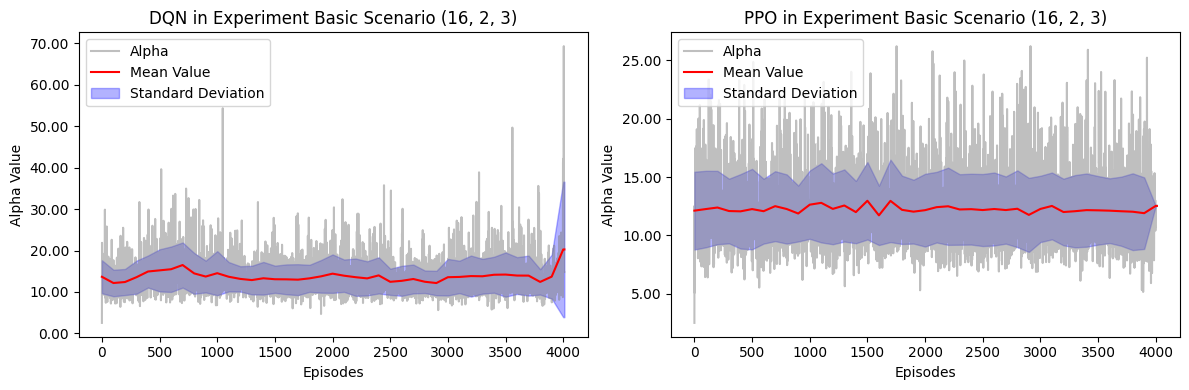

########## Inventory #########


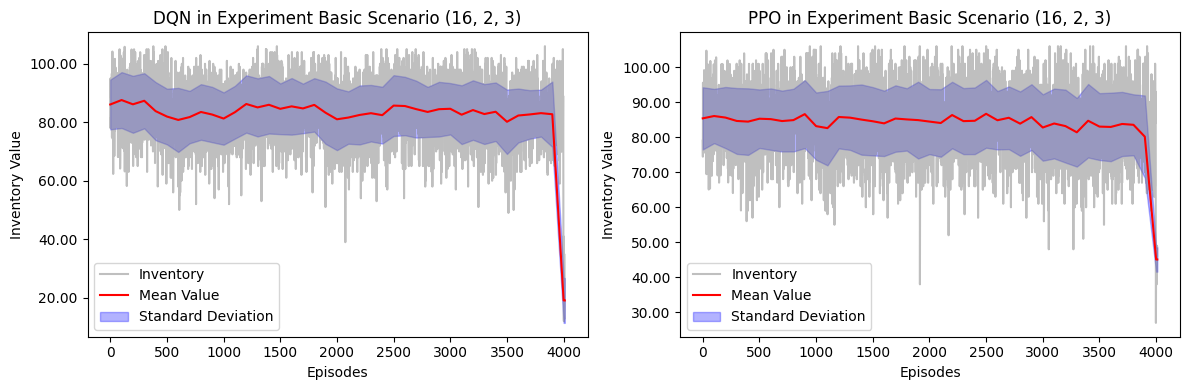

########## Order_waiting_time #########


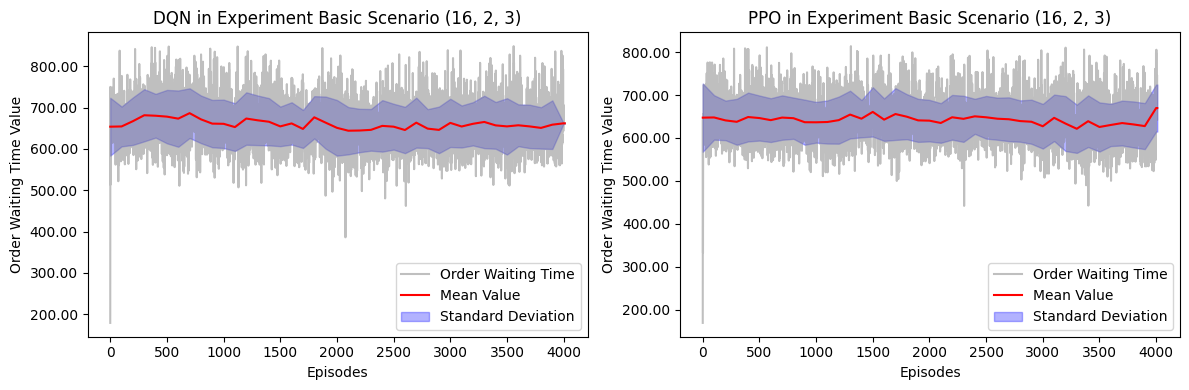

########## Machines_working #########


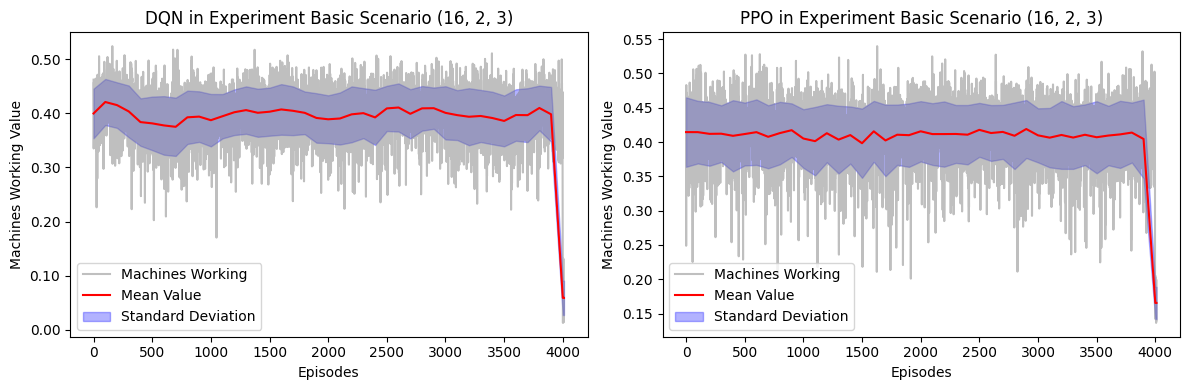

########## Transp_working #########


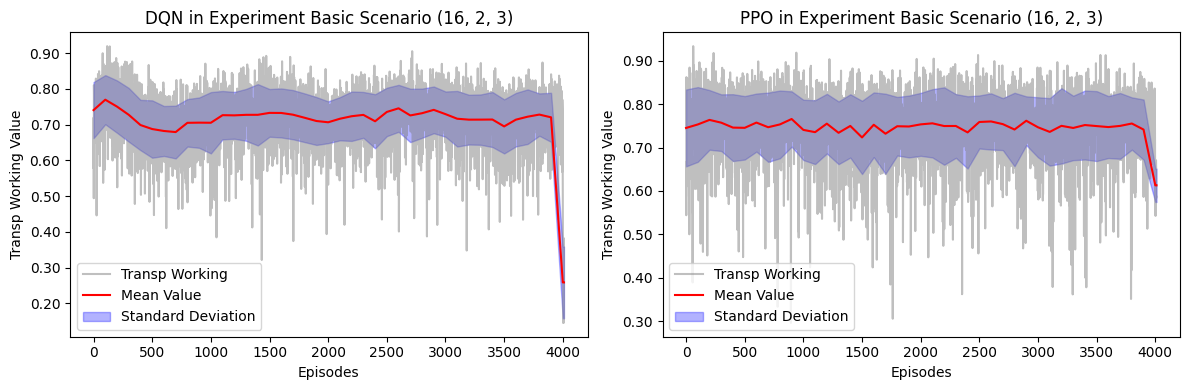

########## Processed_orders #########


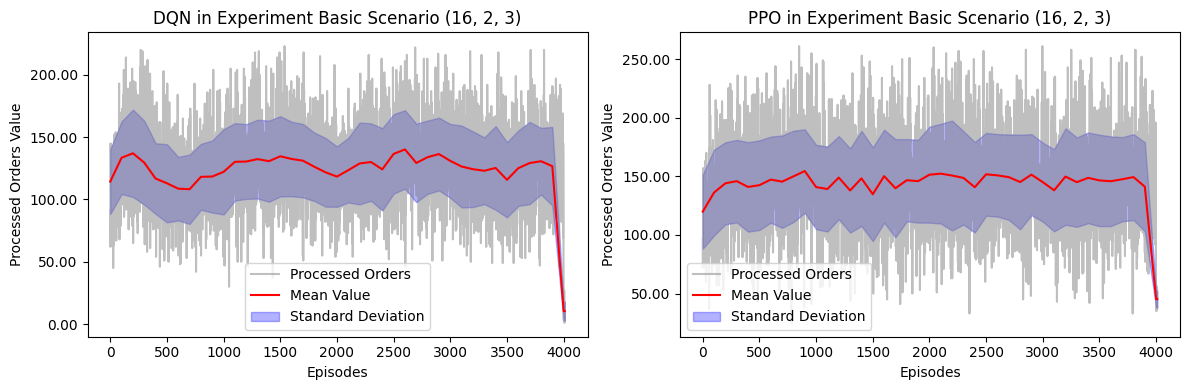

########## Total_reward #########


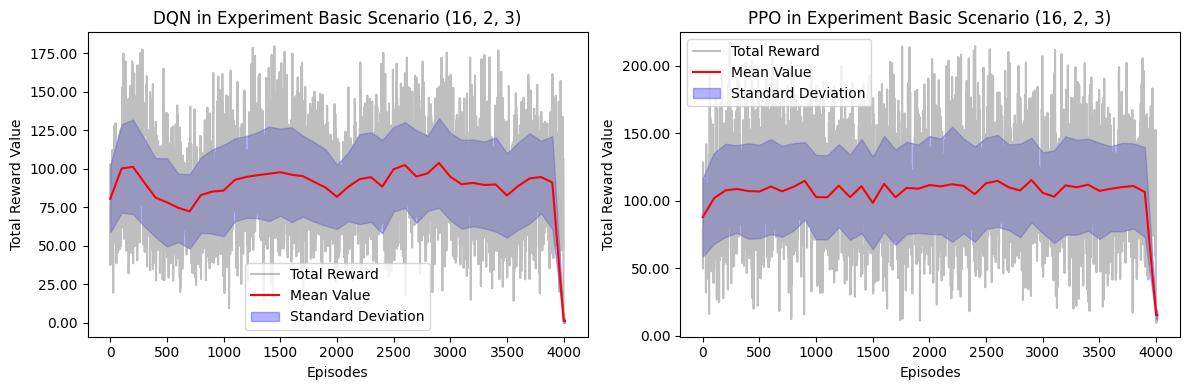

In [27]:
data_names = ['DQN', 'PPO', 'RecPPO', 'GTrXL'] # 'A2C'
#data_names = ['FIFO', 'NJF', 'RANDOM']

kpi_list = ['alpha', 'inventory', 'order_waiting_time', 'machines_working','transp_working', 'processed_orders',
            'total_reward'
            ]
exp_list = [#'Basic Scenario (8, 1, 1)',
            'Basic Scenario (16, 2, 3)',
            #'Adjusted Scenario (16, 2, 3)',
            #'Mixed Scenario (16, 2, 3, 1)',
            #'Mixed Scenario (16, 2, 3, 5)',
            #'Mixed Scenario (16, 2, 3, 10)'
            #'Basic Scenario (36, 2, 3)',
            #'Adjusted Scenario (36, 2, 3)',
            #'Mixed Scenario (36, 2, 3, 1)',
            #'Mixed Scenario (36, 2, 3, 5)',
            #'Mixed Scenario (36, 2, 3, 10)'
            ]
save_paths = [#'Basic Exp (8,1,1)',
              'Basic Exp (16,2,3)',
              #'Adjusted Exp (16,2,3)',
              #'Mixed Exp_1 (16,2,3)',
              #'Mixed Exp_5 (16,2,3)',
              #'Mixed Exp_10 (16,2,3)'
              # 'Basic Exp (36,2,3)',
              #'Adjusted Exp (36,2,3)',
              #'Mixed Exp_1 (36,2,3)',
              #'Mixed Exp_5 (36,2,3)',
              #'Mixed Exp_10 (36,2,3)'
              ]

SAVE = False
SHOW = True
PRINT = True
MEAN = True
PLOT = True
HEUR = False

for i, exp in enumerate(exp_list):
    folder_path = root_path + save_paths[i] + '/'
    logfiles = load_logfiles(folder_path)
    data = []

    for name in data_names:
        try:
            if PRINT: print('###', name, '###')
            ep_log = read_logfiles(path=folder_path, episode_log=logfiles[name][0])
            data.append(ep_log)
            if MEAN  and not HEUR:
                file_path = folder_path + 'Metrics_Mean_GenGap_' + exp + '.txt'
                mean_kpis, genGap = mean_kpi(extract_kpi(ep_log, name), file_path=file_path, printer=PRINT, saver=SAVE, name=name)
            if MEAN and HEUR:
                file_path = folder_path + 'Heuristics_Metrics_Mean_' + exp + '.txt'
                mean_kpis = mean_kpi_heur(extract_kpi(ep_log, name), file_path=file_path, printer=PRINT, saver=SAVE, name=name)
        except Exception:
            print(name, ': not available!')
            continue

    if PLOT:
        for kpi in kpi_list:
            if PRINT: print('##########', kpi.capitalize(), '#########')
            plot_kpi_multiple(data=data, kpi=kpi, data_names=data_names, smoothing=100,
                              exp_name=exp, folder_path=save_paths[i], save=SAVE, show=SHOW)

In [12]:
save_paths = ['Basic Exp (8,1,1)/fig',
              'Basic Exp (36,2,3)/fig',
              'Adjusted Exp (36,2,3)/fig',
              'Mixed Exp_1 (36,2,3)/fig',
              'Mixed Exp_5 (36,2,3)/fig',
              'Mixed Exp_10 (36,2,3)/fig'
              ]

for save_path in save_paths:
    folder_path = root_path + save_path
    file_names = os.listdir(folder_path)
    for file in file_names:
        kpi = file.split(sep='_')
        if len(kpi) == 3:
            kpi = kpi[1].capitalize()
        else:
            kpi = kpi[1].capitalize() + ' ' + kpi[2].capitalize()
        title = kpi + ' of ' + save_path[:-4]
        string_1 = "\{d}egin{b}figure{c}[ht]\n".format(a=repr('\b'), b='{', c='}', d='b') + '\t \centering\n' + '\t \includegraphics[width=0.45\{b}extwidth]{c}{a}{d}\n'.format(a=file, b='t',c='{Bilder/', d='}') + '\t \caption{b}{a}{c}\n'.format(a=title, b='{', c='}') + '\t \label{b}fig:{a}{c}\n'.format(a=file, b='{', c='}') + '\end{b}figure{c}\n'.format(b='{', c='}')

        with open(root_path + 'latex_code.txt', 'ab') as file:
            file.write(string_1.encode('utf-8'))